**Chapter 14 – Recurrent Neural Networks**

_This notebook contains all the sample code and solutions to the exercices in chapter 14._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import tensorflow as tf

# Basic RNNs

## Manual RNN

In [3]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.initialize_all_variables()

In [4]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[-0.36057398 -0.96517926  0.48707351 -0.80243582  0.51278424]
 [-0.96974641 -0.75328994 -0.99739522 -0.9625352  -0.99463832]
 [-0.99899673  0.05547129 -0.99999881 -0.99337244 -0.99999529]
 [-0.99477768  1.         -1.          0.72755075 -0.99999982]]


In [6]:
print(Y1_val)

[[-0.99999082  0.99999517 -1.          0.81121653 -1.        ]
 [-0.53314203  0.99705458  0.99729782  0.96423793 -0.34744576]
 [-0.99949259  0.99999535 -0.99992794  0.66791403 -1.        ]
 [ 0.81199503  0.61446667 -0.99822313 -0.97597146 -0.99247956]]


## Using `rnn()`

In [7]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.initialize_all_variables()

In [8]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [9]:
Y0_val

array([[ 0.07416261,  0.7923516 , -0.05084534,  0.09239607, -0.72693622],
       [-0.68976969,  0.99988675, -0.96813369, -0.51161492, -0.99279863],
       [-0.94353616,  0.99999994, -0.99941975, -0.84038723, -0.9998349 ],
       [-0.98813009,  0.99979234, -0.99949032, -0.98354477, -0.88353568]], dtype=float32)

In [10]:
Y1_val

array([[-0.9907825 ,  1.        , -0.99996603, -0.97120112, -0.99993932],
       [-0.09488045, -0.85075241,  0.63662791, -0.33429465, -0.57341123],
       [-0.98009253,  0.99990934, -0.99606621, -0.94858801, -0.99767119],
       [-0.90000558,  0.80833495, -0.81343043, -0.82144362, -0.87849504]], dtype=float32)

In [11]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [12]:
show_graph(tf.get_default_graph())

## Packing sequences

In [13]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unpack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.pack(output_seqs), perm=[1, 0, 2])

init = tf.initialize_all_variables()

In [14]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [15]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[ 0.99875647 -0.573722   -0.99948245 -0.99564236  0.99102563]
 [ 0.41602549 -0.6023128  -0.31947899 -0.78596532 -0.17525405]
 [ 0.97640204 -0.10612913 -0.97973239 -0.98652101  0.9513914 ]
 [ 0.4300783   0.74443972  0.03451039 -0.96086538  0.47295314]]


## Using `dynamic_rnn()`

In [16]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.initialize_all_variables()

In [17]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    print("outputs =", outputs.eval(feed_dict={X: X_batch}))

outputs = [[[-0.45170557  0.40414917 -0.02957759  0.38428852  0.75689387]
  [-0.9943645   0.99458379 -0.99999291  0.99881893  0.99994969]]

 [[-0.93167132  0.88008887 -0.97291428  0.94692498  0.99657506]
  [-0.28076667  0.66504318  0.16148449 -0.34626469 -0.40937001]]

 [[-0.99339616  0.98101002 -0.99960017  0.99666387  0.99995756]
  [-0.97532713  0.97948372 -0.99930555  0.9608326   0.99441969]]

 [[-0.99968922  0.55740869 -0.99985087  0.99993879  0.99330974]
  [-0.71752405  0.87904817 -0.97039986  0.60248983  0.72734952]]]


In [18]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [19]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_length = tf.placeholder(tf.int32, [None])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, sequence_length=seq_length, dtype=tf.float32)

init = tf.initialize_all_variables()

In [20]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [21]:
print(outputs_val)

[[[-0.83913571  0.52826792  0.128087    0.67568845 -0.22597863]
  [-0.999856    0.99906492 -0.02751926  0.73297024 -0.90167361]]

 [[-0.99741524  0.9603858  -0.00184512  0.89195168 -0.58265227]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99996179  0.99735773 -0.13171493  0.96685493 -0.80157036]
  [-0.96821952  0.99069595  0.22659029  0.17471884 -0.9063077 ]]

 [[ 0.2344414   0.45619255  0.22524668  0.4731124   0.845994  ]
  [-0.90775853  0.71757758  0.42147943  0.35615703  0.2386229 ]]]


In [22]:
print(states_val)

[[-0.999856    0.99906492 -0.02751926  0.73297024 -0.90167361]
 [-0.99741524  0.9603858  -0.00184512  0.89195168 -0.58265227]
 [-0.96821952  0.99069595  0.22659029  0.17471884 -0.9063077 ]
 [-0.90775853  0.71757758  0.42147943  0.35615703  0.2386229 ]]


## Training a sequence classifier

In [23]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.variable_scope("rnn", initializer=tf.contrib.layers.variance_scaling_initializer()):
    basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = fully_connected(states, n_outputs, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.initialize_all_variables()

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [25]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.98 Test accuracy: 0.909
1 Train accuracy: 0.953333 Test accuracy: 0.9369
2 Train accuracy: 0.973333 Test accuracy: 0.9508
3 Train accuracy: 0.973333 Test accuracy: 0.9501
4 Train accuracy: 0.986667 Test accuracy: 0.9606
5 Train accuracy: 0.98 Test accuracy: 0.9633
6 Train accuracy: 0.96 Test accuracy: 0.9658
7 Train accuracy: 0.986667 Test accuracy: 0.9682
8 Train accuracy: 0.98 Test accuracy: 0.9681
9 Train accuracy: 0.98 Test accuracy: 0.9658
10 Train accuracy: 0.986667 Test accuracy: 0.9693
11 Train accuracy: 0.986667 Test accuracy: 0.9697
12 Train accuracy: 0.98 Test accuracy: 0.9726
13 Train accuracy: 0.973333 Test accuracy: 0.9712
14 Train accuracy: 0.966667 Test accuracy: 0.9739
15 Train accuracy: 0.986667 Test accuracy: 0.9741
16 Train accuracy: 0.986667 Test accuracy: 0.9744
17 Train accuracy: 1.0 Test accuracy: 0.9746
18 Train accuracy: 0.98 Test accuracy: 0.9757
19 Train accuracy: 0.973333 Test accuracy: 0.9724
20 Train accuracy: 0.993333 Test accuracy: 0

# Multi-layer RNN

In [26]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons1 = 150
n_neurons2 = 100
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

hidden1 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons1, activation=tf.nn.relu)
hidden2 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons2, activation=tf.nn.relu)
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell([hidden1, hidden2])
outputs, states_tuple = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
states = tf.concat(concat_dim=1, values=states_tuple)
logits = fully_connected(states, n_outputs, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.initialize_all_variables()

In [27]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.933333 Test accuracy: 0.93
1 Train accuracy: 0.993333 Test accuracy: 0.9546
2 Train accuracy: 0.973333 Test accuracy: 0.9643
3 Train accuracy: 0.973333 Test accuracy: 0.9641
4 Train accuracy: 0.973333 Test accuracy: 0.971
5 Train accuracy: 0.98 Test accuracy: 0.9692
6 Train accuracy: 0.993333 Test accuracy: 0.974
7 Train accuracy: 0.973333 Test accuracy: 0.9727
8 Train accuracy: 0.993333 Test accuracy: 0.9754
9 Train accuracy: 0.993333 Test accuracy: 0.9758
10 Train accuracy: 0.986667 Test accuracy: 0.9788
11 Train accuracy: 0.98 Test accuracy: 0.9772
12 Train accuracy: 0.96 Test accuracy: 0.9803
13 Train accuracy: 0.98 Test accuracy: 0.9812
14 Train accuracy: 0.986667 Test accuracy: 0.9803
15 Train accuracy: 0.993333 Test accuracy: 0.9814
16 Train accuracy: 0.993333 Test accuracy: 0.9767
17 Train accuracy: 0.993333 Test accuracy: 0.9795
18 Train accuracy: 0.993333 Test accuracy: 0.9829
19 Train accuracy: 0.993333 Test accuracy: 0.9815
20 Train accuracy: 1.0 Test ac

# Time series

In [28]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


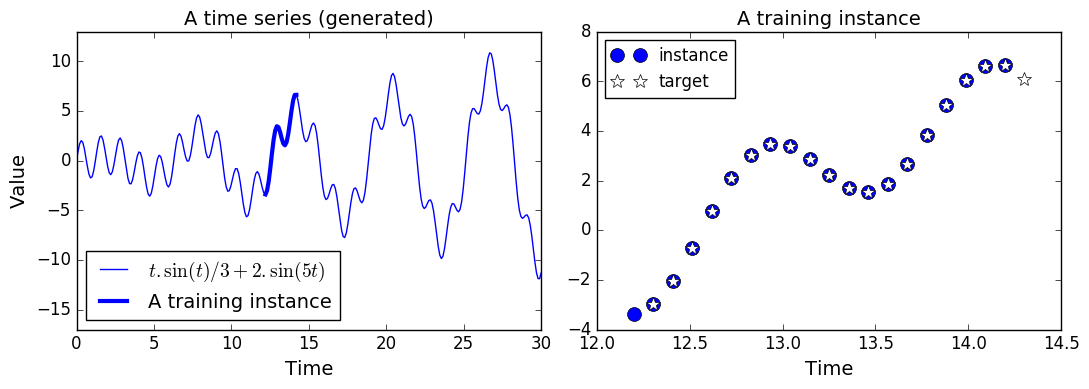

In [29]:
t = np.linspace(t_min, t_max, (t_max - t_min) // resolution)

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [30]:
X_batch, y_batch = next_batch(1, n_steps)

In [31]:
np.c_[X_batch[0], y_batch[0]]

array([[ 0.3266291 , -0.97081587],
       [-0.97081587, -2.09298955],
       [-2.09298955, -2.84017944],
       [-2.84017944, -3.10464787],
       [-3.10464787, -2.89622372],
       [-2.89622372, -2.33910087],
       [-2.33910087, -1.64063575],
       [-1.64063575, -1.03979198],
       [-1.03979198, -0.74786335],
       [-0.74786335, -0.89599678],
       [-0.89599678, -1.50237198],
       [-1.50237198, -2.46708161],
       [-2.46708161, -3.59597343],
       [-3.59597343, -4.64762444],
       [-4.64762444, -5.39195331],
       [-5.39195331, -5.66612695],
       [-5.66612695, -5.41407933],
       [-5.41407933, -4.69997176],
       [-4.69997176, -3.69230347],
       [-3.69230347, -2.6225661 ]])

## Using an `OuputProjectionWrapper`

In [32]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.initialize_all_variables()

In [33]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 19547.1
100 	MSE: 615.675
200 	MSE: 262.064
300 	MSE: 108.71
400 	MSE: 71.5897
500 	MSE: 60.9463
600 	MSE: 52.3459
700 	MSE: 54.5842
800 	MSE: 59.7404
900 	MSE: 58.6444
[[[-3.49082494]
  [-2.49961495]
  [-1.19460428]
  [ 0.54534876]
  [ 2.08690691]
  [ 3.12661314]
  [ 3.6056354 ]
  [ 3.36597252]
  [ 2.79547858]
  [ 2.19066119]
  [ 1.6474148 ]
  [ 1.46276832]
  [ 1.84827828]
  [ 2.72194839]
  [ 3.91095877]
  [ 5.09868765]
  [ 6.09352255]
  [ 6.65207148]
  [ 6.63699913]
  [ 6.05670404]]]


Saving figure time_series_pred_plot


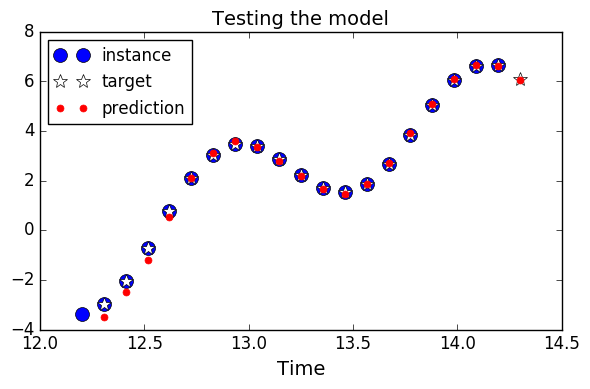

In [34]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an `OutputProjectionWrapper`

In [35]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = fully_connected(stacked_rnn_outputs, n_outputs, activation_fn=None)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.initialize_all_variables()

In [36]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 17686.2
100 	MSE: 662.248
200 	MSE: 264.614
300 	MSE: 130.89
400 	MSE: 66.8613
500 	MSE: 57.3093
600 	MSE: 58.1215
700 	MSE: 50.4261
800 	MSE: 55.0233
900 	MSE: 46.2155
[[[-3.48863339]
  [-2.53098774]
  [-1.18000042]
  [ 0.611229  ]
  [ 2.14753366]
  [ 3.03904676]
  [ 3.52505374]
  [ 3.32288671]
  [ 2.81675553]
  [ 2.15579176]
  [ 1.66734779]
  [ 1.46762455]
  [ 1.8229965 ]
  [ 2.74252129]
  [ 3.94347739]
  [ 5.15296268]
  [ 6.18588161]
  [ 6.71781921]
  [ 6.66168833]
  [ 6.04868698]]]


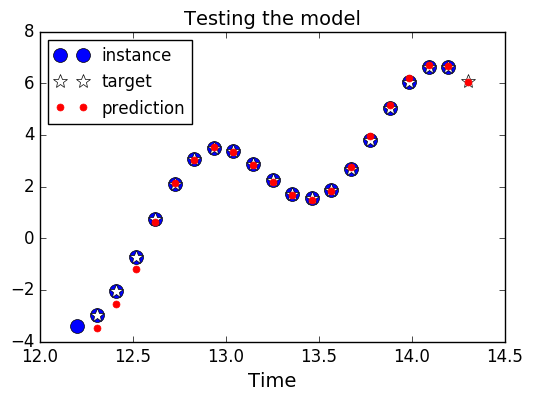

In [37]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

0 	MSE: 19871.8
100 	MSE: 612.568
200 	MSE: 347.469
300 	MSE: 115.234
400 	MSE: 100.701
500 	MSE: 54.1295
600 	MSE: 52.9499
700 	MSE: 49.8591
800 	MSE: 45.2352
900 	MSE: 41.3012
1000 	MSE: 49.4969
1100 	MSE: 48.0107
1200 	MSE: 51.8899
1300 	MSE: 40.666
1400 	MSE: 49.1267
1500 	MSE: 46.3022
1600 	MSE: 52.4641
1700 	MSE: 48.3006
1800 	MSE: 43.9769
1900 	MSE: 52.8979


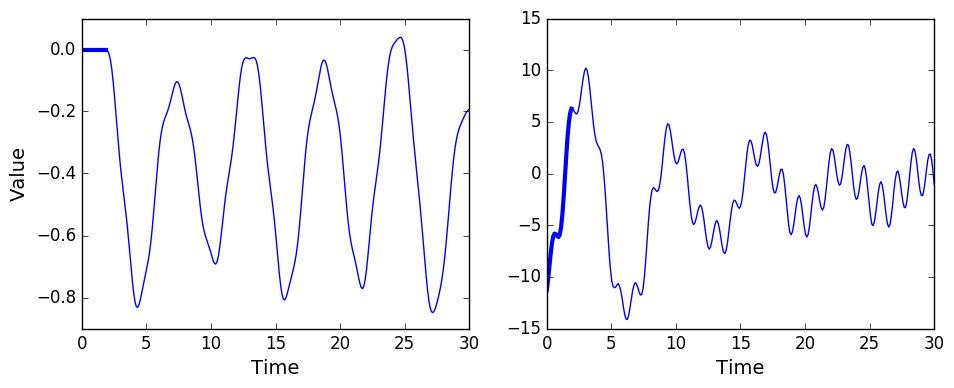

In [38]:
n_iterations = 2000
batch_size = 50
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
#save_fig("creative_sequence_plot")
plt.show()

# Deep RNN

## MultiRNNCell

In [39]:
tf.reset_default_graph()

n_inputs = 2
n_neurons = 100
n_layers = 3
n_steps = 5
keep_prob = 0.5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell([basic_cell] * n_layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.initialize_all_variables()

In [40]:
X_batch = rnd.rand(2, n_steps, n_inputs)

In [41]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [42]:
outputs_val.shape

(2, 5, 100)

## Dropout

In [43]:
tf.reset_default_graph()
from tensorflow.contrib.layers import fully_connected

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

keep_prob = 0.5
learning_rate = 0.001

is_training = True

def deep_rnn_with_dropout(X, y, is_training):
    cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
    if is_training:
        cell = tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
    multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell([cell] * n_layers)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = fully_connected(stacked_rnn_outputs, n_outputs, activation_fn=None)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

    loss = tf.reduce_sum(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    return outputs, loss, training_op

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
outputs, loss, training_op = deep_rnn_with_dropout(X, y, is_training)
init = tf.initialize_all_variables()
saver = tf.train.Saver()

In [44]:
n_iterations = 2000
batch_size = 50

with tf.Session() as sess:
    if is_training:
        init.run()
        for iteration in range(n_iterations):
            X_batch, y_batch = next_batch(batch_size, n_steps)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 100 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                print(iteration, "\tMSE:", mse)
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
        plt.title("Testing the model", fontsize=14)
        plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
        plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
        plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.show()

0 	MSE: 15946.8
100 	MSE: 5075.86
200 	MSE: 4079.82
300 	MSE: 3664.84
400 	MSE: 3786.28
500 	MSE: 4205.34
600 	MSE: 3247.28
700 	MSE: 2730.68
800 	MSE: 2402.18
900 	MSE: 2324.29
1000 	MSE: 3058.12
1100 	MSE: 2319.52
1200 	MSE: 2507.9
1300 	MSE: 2660.9
1400 	MSE: 2211.66
1500 	MSE: 3052.62
1600 	MSE: 1874.06
1700 	MSE: 2435.98
1800 	MSE: 2694.25
1900 	MSE: 2124.64


# LSTM

In [45]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
multi_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell]*3)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = fully_connected(top_layer_h_state, n_outputs, activation_fn=None, scope="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.initialize_all_variables()

In [46]:
states

(LSTMStateTuple(c=<tf.Tensor 'RNN/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'RNN/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'RNN/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'RNN/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'RNN/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'RNN/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [47]:
top_layer_h_state

<tf.Tensor 'RNN/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [48]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.973333 Test accuracy = 0.9571
Epoch 1 Train accuracy = 0.973333 Test accuracy = 0.9675
Epoch 2 Train accuracy = 0.973333 Test accuracy = 0.9776
Epoch 3 Train accuracy = 0.993333 Test accuracy = 0.9784
Epoch 4 Train accuracy = 0.986667 Test accuracy = 0.9832
Epoch 5 Train accuracy = 1.0 Test accuracy = 0.9864
Epoch 6 Train accuracy = 1.0 Test accuracy = 0.983
Epoch 7 Train accuracy = 0.993333 Test accuracy = 0.9873
Epoch 8 Train accuracy = 0.986667 Test accuracy = 0.9866
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9844


# Distributing layers across devices

In [49]:
import tensorflow as tf

class DeviceCellWrapper(tf.nn.rnn_cell.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [50]:
tf.reset_default_graph()

n_inputs = 5
n_neurons = 100
devices = ["/cpu:0"]*5
n_steps = 20
X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
lstm_cells = [DeviceCellWrapper(device, tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons))
              for device in devices]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
init = tf.initialize_all_variables()

In [51]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: rnd.rand(2, n_steps, n_inputs)}))

[[[ -3.19280400e-04  -6.45867288e-02  -4.05497178e-02 ...,   2.24182531e-02
     1.05714833e-03  -3.62126604e-02]
  [  1.31117716e-03  -1.34218305e-01   2.78399549e-02 ...,   1.01721119e-02
     6.72215456e-03  -1.26591250e-02]
  [  8.24499577e-02   3.70293148e-02   7.07458258e-02 ...,  -7.75473192e-02
    -3.04776919e-03  -9.04885828e-02]
  ..., 
  [  2.61661261e-01  -5.99679686e-02  -1.49484500e-01 ...,  -6.02332726e-02
    -2.87173074e-02  -3.84434253e-01]
  [  1.17578521e-01  -1.90875143e-01   1.51023969e-01 ...,   1.33811116e-01
     1.29388228e-01  -2.46712655e-01]
  [  7.38234669e-02   8.04797746e-04  -1.23940095e-01 ...,  -3.29736441e-01
    -8.43329206e-02  -2.79146999e-01]]

 [[  6.49656542e-03  -5.02935871e-02  -6.24618940e-02 ...,   7.72490093e-05
     1.05972281e-02  -5.48918769e-02]
  [ -8.00711475e-03  -1.65640131e-01   5.02453074e-02 ...,   5.03446050e-02
    -1.36158708e-02   2.31136065e-02]
  [  2.44874973e-02   6.68547675e-02  -3.99295576e-02 ...,  -1.12335183e-01
  

# Embeddings

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

## Fetch the data

In [52]:
from six.moves import urllib

import os
import zipfile
import urllib.request

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [53]:
words = fetch_words_data()

In [54]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [55]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [56]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5244, 3084,   12,    6,  195,    2, 3135,   46,   59]))

In [57]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'guided inducted as a term of presidency first used'

In [58]:
words[24], data[24]

('culottes', 0)

## Generate batches

In [59]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [60]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [61]:
batch, [vocabulary[word] for word in batch]

(array([3084, 3084,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [62]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5244],
        [   6],
        [3084],
        [  12],
        [ 195],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

## Build the model

In [63]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = rnd.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [64]:
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Look up embeddings for inputs.
init_embeddings = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeddings)
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), reduction_indices=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.initialize_all_variables()

## Train the model

In [65]:
num_steps = 100001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  289.260375977
Nearest to on: virulent, baudelaire, wattle, solzhenitsyn, yevgeny, citric, firewall, wrecked,
Nearest to have: complexes, interest, dandridge, impart, resolves, amphitheatre, disparate, museu,
Nearest to which: confusion, singled, may, gravitation, laboratories, recalled, faroe, automatism,
Nearest to in: respects, kettering, forster, hackney, faltering, worship, champlain, goodfellas,
Nearest to if: tsuka, debated, cranes, arises, rake, goncourt, hilly, equestrian,
Nearest to system: shahi, abandonware, goblin, crowded, sleeper, codepages, patriotic, kings,
Nearest to his: defy, squirt, crossbows, potsdam, catastrophes, invalidating, neuroscientist, ceded,
Nearest to war: benign, exons, cva, hammerhead, volunteer, habitually, trait, kabyle,
Nearest to would: cke, nanoscale, munitions, nails, aedh, serpents, propagandist, terrier,
Nearest to a: woodpecker, ratchet, nbs, horticultural, warhol, implied, ilya, fairfax,
Nearest to over

Let's save the final embeddings (of course you can use a TensorFlow `Saver` if you prefer):

In [66]:
np.save("my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [67]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

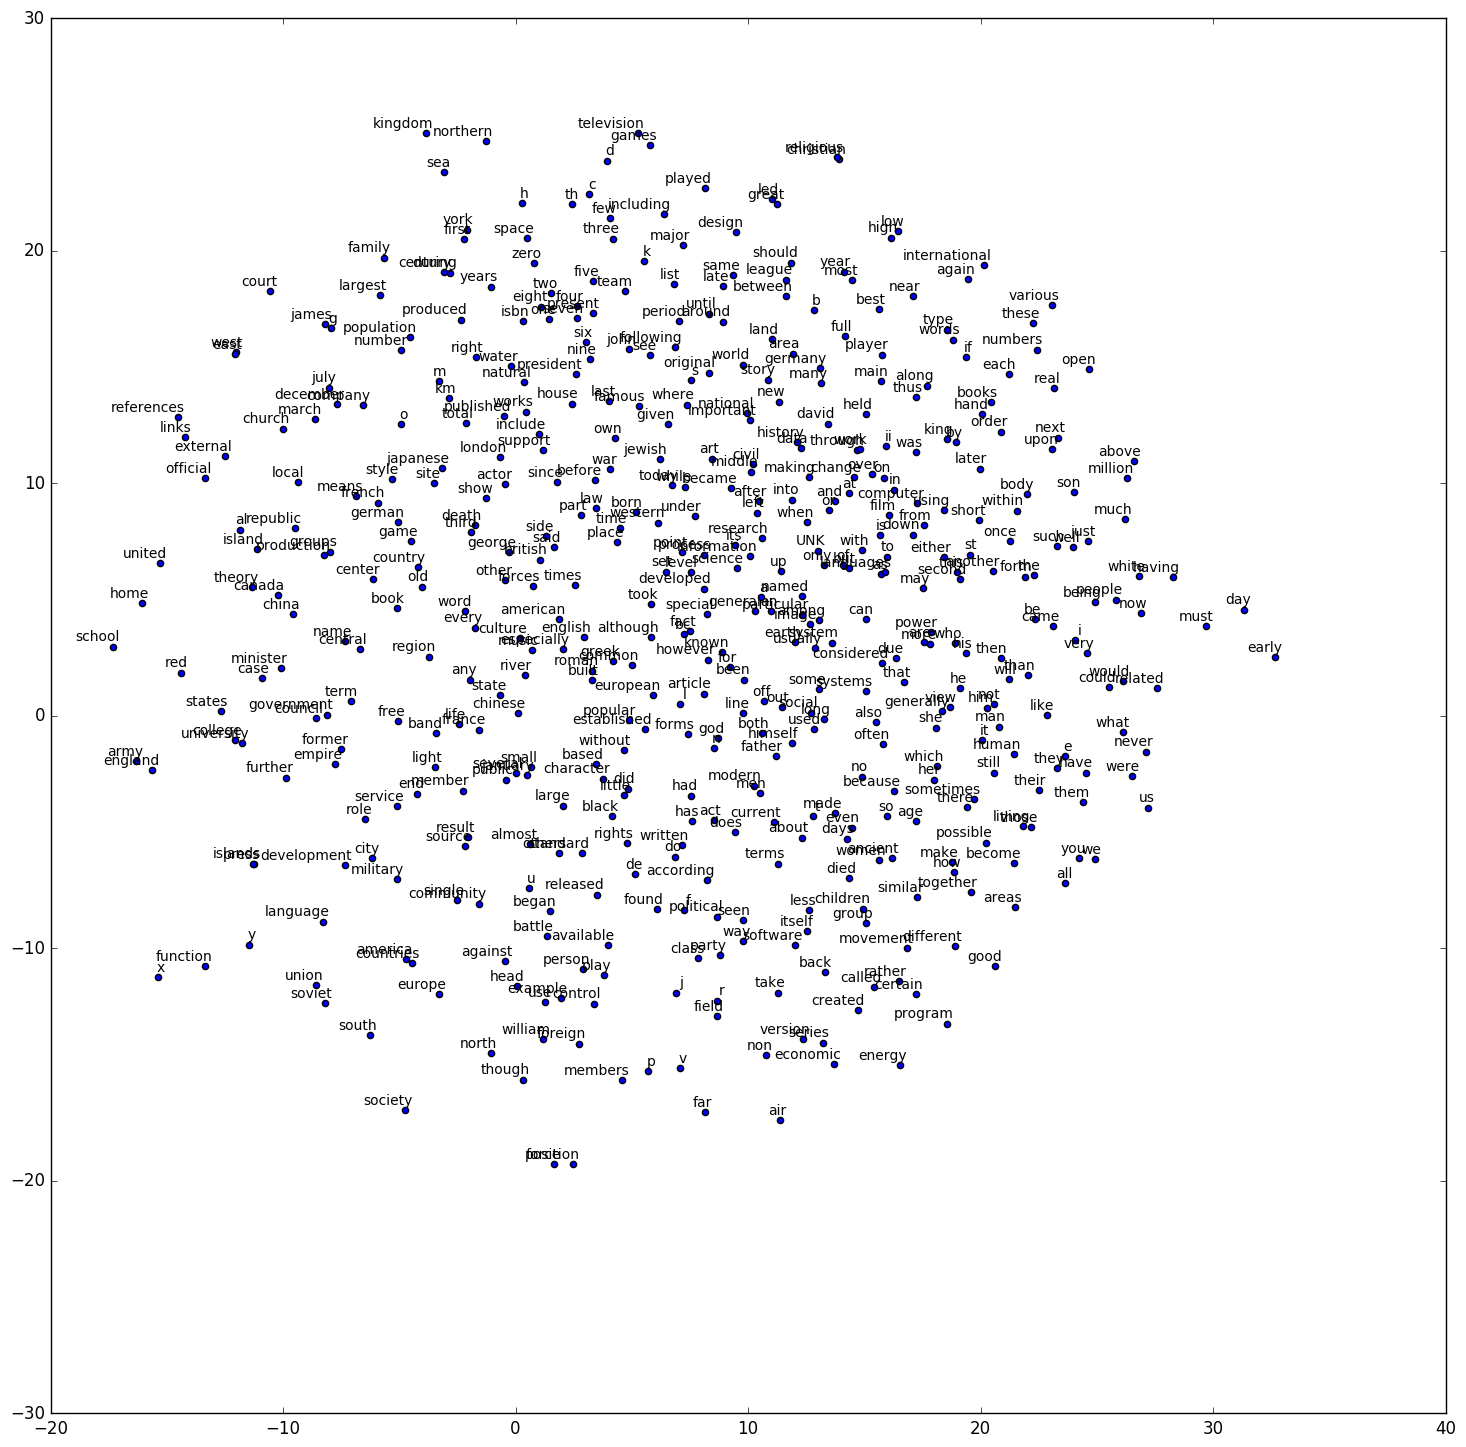

In [68]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Machine Translation

The `basic_rnn_seq2seq()` function creates a simple Encoder/Decoder model: it first runs an RNN to encode `encoder_inputs` into a state vector, then runs a decoder initialized with the last encoder state on `decoder_inputs`. Encoder and decoder use the same RNN cell type but they don't share parameters.

In [69]:
import tensorflow as tf
tf.reset_default_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unpack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unpack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * n_layers)

output_seqs, states = tf.nn.seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.pack(output_seqs), perm=[1, 0, 2])

In [70]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(logits_flat, Y_target_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.initialize_all_variables()

# Exercise solutions

**Coming soon**